In [ ]:
!nvidia-smi

Sun Feb 21 21:16:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Import Libraries

In [ ]:
import torch

if torch.cuda.is_available():        
    device = torch.device("cuda")
    print(' GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

 GPU: Tesla T4


In [ ]:
!pip install nlp transformers pytorch_lightning sentencepiece

     |████████████████████████████████| 1.7MB 9.0MB/s 
     |████████████████████████████████| 1.8MB 50.7MB/s 
     |████████████████████████████████| 819kB 50.2MB/s 
     |████████████████████████████████| 1.2MB 48.1MB/s 
     |████████████████████████████████| 20.7MB 1.2MB/s 
     |████████████████████████████████| 245kB 45.6MB/s 
     |████████████████████████████████| 3.2MB 52.9MB/s 
     |████████████████████████████████| 890kB 47.1MB/s 
     |████████████████████████████████| 829kB 45.1MB/s 
     |████████████████████████████████| 102kB 15.5MB/s 
     |████████████████████████████████| 276kB 52.1MB/s 
     |████████████████████████████████| 1.3MB 46.6MB/s 
     |████████████████████████████████| 143kB 54.9MB/s 
     |████████████████████████████████| 296kB 56.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=ce96541836b827bb26ed903e86d1dc35b4fe4050a96e6792d6cd67f016f7231a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/

In [ ]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import WandbLogger
from nlp import load_metric

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
# Increase the plot size and font size.
plt.rcParams["figure.figsize"] = (12,6)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

# Seaborn options
sns.set(style="darkgrid", palette=HAPPY_COLORS_PALETTE, font_scale=1.4)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Loading


In [ ]:
from nlp import list_datasets
datasets_list = list_datasets()
print(', '.join(dataset.id for dataset in datasets_list))

acronym_identification, ade_corpus_v2, adversarial_qa, aeslc, afrikaans_ner_corpus, ag_news, ai2_arc, air_dialogue, ajgt_twitter_ar, allegro_reviews, allocine, alt, amazon_polarity, amazon_reviews_multi, amazon_us_reviews, ambig_qa, amttl, anli, app_reviews, aqua_rat, aquamuse, ar_cov19, ar_res_reviews, ar_sarcasm, arabic_billion_words, arabic_pos_dialect, arabic_speech_corpus, arcd, arsentd_lev, art, arxiv_dataset, aslg_pc12, asnq, asset, assin, assin2, atomic, autshumato, bbc_hindi_nli, bc2gm_corpus, best2009, bianet, bible_para, big_patent, billsum, bing_coronavirus_query_set, biomrc, blended_skill_talk, blimp, blog_authorship_corpus, bn_hate_speech, bookcorpus, bookcorpusopen, boolq, bprec, break_data, brwac, bsd_ja_en, bswac, c3, c4, cail2018, caner, capes, catalonia_independence, cawac, cc100, cc_news, cdsc, cdt, cfq, chr_en, cifar10, cifar100, circa, civil_comments, clickbait_news_bg, climate_fever, clinc_oos, clue, cmrc2018, cnn_dailymail, coached_conv_pref, coarse_discourse, c

In [ ]:
from google.colab import drive
drive.mount('/gdrive') 

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
from nlp import load_dataset
dataset = load_dataset('wikihow', 'all', data_dir='/gdrive/MyDrive/text_summarizer/')

In [ ]:
print(dataset.keys())

dict_keys(['train', 'validation', 'test'])


In [ ]:
print("Size of train dataset: ", dataset['train'].shape)

Size of train dataset:  (157252, 3)


In [ ]:
print("Size of Validation dataset: ", dataset['validation'].shape)

Size of Validation dataset:  (5599, 3)


In [ ]:
print("Size of ca test dataset: ", dataset['test'].shape)

Size of ca test dataset:  (5577, 3)


In [ ]:
print(dataset['train'][0].keys())

dict_keys(['headline', 'text', 'title'])


In [ ]:
print(" Example of text: ", dataset['train'][2]['text'])

 Example of text:  It is possible to become a VFX artist without a college degree, but the path is often easier with one. VFX artists usually major in fine arts, computer graphics, or animation. Choose a college with a reputation for strength in these areas and a reputation for good job placement for graduates. The availability of internships is another factor to consider.Out of the jobs advertised for VFX artists, a majority at any given time specify a bachelor’s degree as a minimum requirement for applicants.;
, Some studios offer short-term programs for people who want to learn more about VFX artistry without pursuing a college degree. Enrolling in these programs can be expensive as financial aid isn’t always offered, but they usually have the most cutting edge technology for you to learn from., Although you may create some hand sketches, the majority of your work will be completed on the computer using the most up-to-date programs. Stay informed about the newest software advances b

In [ ]:
print(" Example of Summary: ", dataset['train'][0]['headline'])

 Example of Summary:  Keep related supplies in the same area.
Make an effort to clean a dedicated workspace after every session.
Place loose supplies in large, clearly visible containers.
Use clotheslines and clips to hang sketches, photos, and reference material.
Use every inch of the room for storage, especially vertical space.
Use chalkboard paint to make space for drafting ideas right on the walls.
Purchase a label maker to make your organization strategy semi-permanent.
Make a habit of throwing out old, excess, or useless stuff each month.


In [ ]:
print(" Example of Title: ", dataset['train'][0]['title'])

 Example of Title:  How to Be an Organized Artist1


### Data Analysis

In [ ]:
tiny_dataset = dataset['train'].select(list(range(0, 100)))
text_len = []
summary_len=[]

In [ ]:
for i in range(len(tiny_dataset)):
    example = tiny_dataset[i]
    text_example = example['text']
    text_example = text_example.replace('\n','')
    text_words = text_example.split()
    text_len.append(len(text_words))
    summary_example = example['headline']
    summary_example = summary_example.replace('\n','')
    summary_words = summary_example.split()
    summary_len.append(len(summary_words))

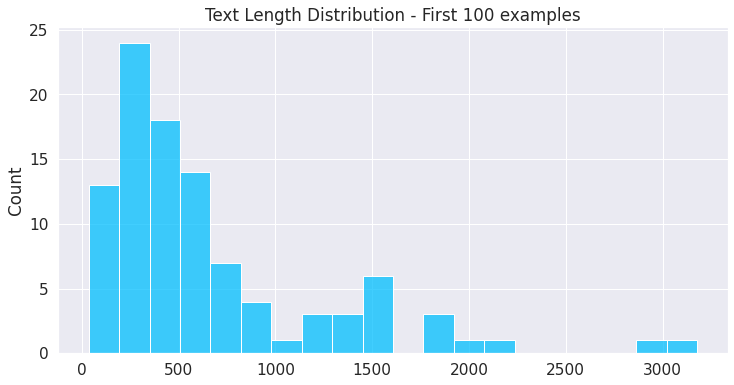

In [ ]:

sns.histplot(text_len,bins=20)
plt.title('Text Length Distribution - First 100 examples')
plt.show()

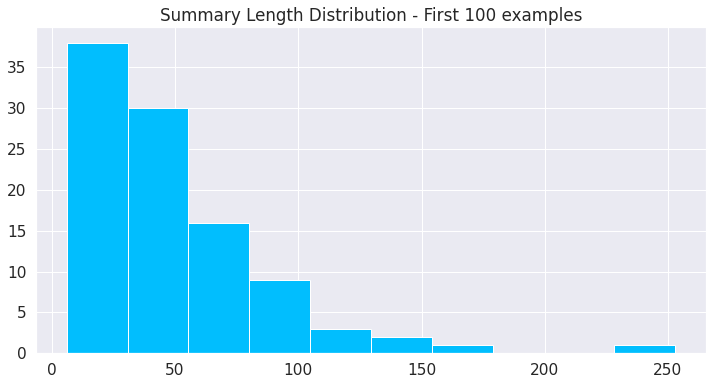

In [ ]:
plt.hist(summary_len)
plt.title('Summary Length Distribution - First 100 examples')
plt.show()

In [ ]:
print("Average Length of text: ", sum(text_len)/len(text_len))

Average Length of text:  662.69


In [ ]:
print("Average Length of Summary: ", sum(summary_len)/len(summary_len))

Average Length of Summary:  48.8


## Define Model

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [ ]:
class T5FineTuner(pl.LightningModule):
    def __init__(self, hparams):
        super(T5FineTuner, self).__init__()
        self.hparams = hparams        
        self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
        self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
        self.rouge_metric = load_metric('rouge') 
        
        if self.hparams.freeze_embeds:
            self.freeze_embeds()
        if self.hparams.freeze_encoder:
            self.freeze_params(self.model.get_encoder())
            assert_all_frozen(self.model.get_encoder())
            
            
        n_observations_per_split = {
            "train": self.hparams.n_train,
            "validation": self.hparams.n_val,
            "test": self.hparams.n_test,
        }
        self.n_obs = {k: v if v >= 0 else None for k, v in n_observations_per_split.items()}
        
    
    def freeze_params(self, model):
        for par in model.parameters():
            par.requires_grad = False
            
            
    def freeze_embeds(self):
        """Freeze token embeddings and positional embeddings for bart, just token embeddings for t5."""
        try:
            self.freeze_params(self.model.model.shared)
            for d in [self.model.model.encoder, self.model.model.decoder]:
                freeze_params(d.embed_positions)
                freeze_params(d.embed_tokens)
        except AttributeError:
            self.freeze_params(self.model.shared)
            for d in [self.model.encoder, self.model.decoder]:
                self.freeze_params(d.embed_tokens)
    
    def lmap(self, f, x):
        """list(map(f, x))"""
        return list(map(f, x))
    

    def is_logger(self):
        return self.trainer.proc_rank <= 0
    
    
    def parse_score(self, result):
        return {k: round(v.mid.fmeasure * 100, 4) for k, v in result.items()}
        
    def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            lm_labels=lm_labels,
    )

    def _step(self, batch):
        lm_labels = batch["target_ids"]
        lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            lm_labels=lm_labels,
            decoder_attention_mask=batch['target_mask']
        )

        loss = outputs[0]

        return loss
    
    
    def ids_to_clean_text(self, generated_ids):
        gen_text = self.tokenizer.batch_decode(
            generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
        )
        return self.lmap(str.strip, gen_text)
    
    
    def _generative_step(self, batch) :
        
        t0 = time.time()
        
        generated_ids = self.model.generate(
            batch["source_ids"],
            attention_mask=batch["source_mask"],
            use_cache=True,
            decoder_attention_mask=batch['target_mask'],
            max_length=150, 
            num_beams=2,
            repetition_penalty=2.5, 
            length_penalty=1.0, 
            early_stopping=True
        )
        preds = self.ids_to_clean_text(generated_ids)
        target = self.ids_to_clean_text(batch["target_ids"])
            
        gen_time = (time.time() - t0) / batch["source_ids"].shape[0]  
    
        loss = self._step(batch)
        base_metrics = {'val_loss': loss}
#         rouge: Dict = self.calc_generative_metrics(preds, target)
        summ_len = np.mean(self.lmap(len, generated_ids))
        base_metrics.update(gen_time=gen_time, gen_len=summ_len, preds=preds, target=target)
        self.rouge_metric.add_batch(preds, target)
        
#         rouge_results = self.rouge_metric.compute() 
#         rouge_dict = self.parse_score(rouge_results)
#         base_metrics.update(rouge1=rouge_dict['rouge1'], rougeL=rouge_dict['rougeL'])
        
        return base_metrics
    

    def training_step(self, batch, batch_idx):
        loss = self._step(batch)

        tensorboard_logs = {"train_loss": loss}
        return {"loss": loss, "log": tensorboard_logs}
  
    def training_epoch_end(self, outputs):
        avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
        tensorboard_logs = {"avg_train_loss": avg_train_loss}
        return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        return self._generative_step(batch)
    
  
    def validation_epoch_end(self, outputs):
        
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        tensorboard_logs = {"val_loss": avg_loss}
        
        rouge_results = self.rouge_metric.compute() 
        rouge_dict = self.parse_score(rouge_results)
    
        tensorboard_logs.update(rouge1=rouge_dict['rouge1'], rougeL=rouge_dict['rougeL'])
        
        ## Clear out the lists for next epoch
        self.target_gen= []
        self.prediction_gen=[]
        return {"avg_val_loss": avg_loss, 
                "rouge1" : rouge_results['rouge1'],
                "rougeL" : rouge_results['rougeL'],
                "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def configure_optimizers(self):
        "Prepare optimizer and schedule (linear warmup and decay)"

        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        self.opt = optimizer
        return [optimizer]
  
    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None, using_native_amp=False):
        if self.trainer.use_tpu:
            xm.optimizer_step(optimizer)
        else:
            optimizer.step()
        optimizer.zero_grad()
        self.lr_scheduler.step()
  
    def get_tqdm_dict(self):
        tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

        return tqdm_dict
    

    def train_dataloader(self):   
        n_samples = self.n_obs['train']
        train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", num_samples=n_samples, args=self.hparams)
        dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
        t_total = (
            (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
            // self.hparams.gradient_accumulation_steps
            * float(self.hparams.num_train_epochs)
        )
        scheduler = get_linear_schedule_with_warmup(
            self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
        )
        self.lr_scheduler = scheduler
        return dataloader

    def val_dataloader(self):
        n_samples = self.n_obs['validation']
        validation_dataset = get_dataset(tokenizer=self.tokenizer, type_path="validation", num_samples=n_samples, args=self.hparams)
        
        return DataLoader(validation_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)
    
    
    def test_dataloader(self):
        n_samples = self.n_obs['test']
        test_dataset = get_dataset(tokenizer=self.tokenizer, type_path="test", num_samples=n_samples, args=self.hparams)
        
        return DataLoader(test_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

In [ ]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
    def on_validation_end(self, trainer, pl_module):
        logger.info("***** Validation results *****")
        if pl_module.is_logger():
            metrics = trainer.callback_metrics
            # Log results
            for key in sorted(metrics):
                if key not in ["log", "progress_bar"]:
                    logger.info("{} = {}\n".format(key, str(metrics[key])))

    def on_test_end(self, trainer, pl_module):
        logger.info("***** Test results *****")

        if pl_module.is_logger():
            metrics = trainer.callback_metrics

            # Log and save results to file
            output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
            with open(output_test_results_file, "w") as writer:
                for key in sorted(metrics):
                    if key not in ["log", "progress_bar"]:
                        logger.info("{} = {}\n".format(key, str(metrics[key])))
                        writer.write("{} = {}\n".format(key, str(metrics[key])))

## Dataset Loader

In [ ]:
class wikihow(Dataset):
    def __init__(self, tokenizer, type_path, num_samples, input_length, output_length, print_text=False):         
        self.dataset =  load_dataset('wikihow', 'all', data_dir='data/', split=type_path)
        if num_samples:
            self.dataset = self.dataset.select(list(range(0, num_samples)))
        self.input_length = input_length
        self.tokenizer = tokenizer
        self.output_length = output_length
        self.print_text = print_text
  
    def __len__(self):
        return self.dataset.shape[0]
    
    def clean_text(self, text):
        text = text.replace('Example of text:', '')
        text = text.replace('Example of Summary:', '')
        text = text.replace('\n','')
        text = text.replace('``', '')
        text = text.replace('"', '')
        
        return text
    
    
    def convert_to_features(self, example_batch):
        # Tokenize contexts and questions (as pairs of inputs)
        
        if self.print_text:
            print("Input Text: ", self.clean_text(example_batch['text']))
#         input_ = self.clean_text(example_batch['text']) + " </s>"
#         target_ = self.clean_text(example_batch['headline']) + " </s>"
        
        input_ = self.clean_text(example_batch['text'])
        target_ = self.clean_text(example_batch['headline'])
        
        source = self.tokenizer.batch_encode_plus([input_], max_length=self.input_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
        
        targets = self.tokenizer.batch_encode_plus([target_], max_length=self.output_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
    
       
        return source, targets
  
    def __getitem__(self, index):
        source, targets = self.convert_to_features(self.dataset[index])
        
        source_ids = source["input_ids"].squeeze()
        target_ids = targets["input_ids"].squeeze()

        src_mask    = source["attention_mask"].squeeze()
        target_mask = targets["attention_mask"].squeeze()

        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
        
  

### Tokenizer


In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')
dataset = wikihow(tokenizer, 'validation', None, 512, 150, True)
len(dataset)

5599

In [ ]:
data = dataset[50]
print()
print("Shape of Tokenized Text: ", data['source_ids'].shape)
print()
print("Sanity check - Decode Text: ", tokenizer.decode(data['source_ids']))
print("====================================")
print("Sanity check - Decode Summary: ", tokenizer.decode(data['target_ids']))


Shape of Tokenized Text:  torch.Size([512])

Sanity check - Decode Text:  For the first 3 weeks of life, feed them a starter diet that is 18-20% protein and consists of small pellets (about 1/8).Duck food can be bought at your local pet store. Some reputable manufacturers of duck food are Purina, Mazuri, or Gunter.Though chicken feed can be substituted for duck food, chicken feed should not be fed to ducklings.Once the ducklings reach 20 weeks of age, you can substitute duck food for chicken feed with the same amount of protein.;, Male and female ducks will both need the same amount of protein. Check the back of your duck food bag for nutritional information. You can begin to feed the female ducks this higher protein diet in the spring time, when they are likely to begin laying eggs. These treats should compromise no more than 15-20% of a duck’s diet. Cut all treats into small pieces. You can also let your duck graze outside, provided the area they are grazing has no pesticides or oth

## Hyperparameters

In [ ]:
args_dict = dict(
    output_dir="/checkpoint", # path to save the checkpoints
    model_name_or_path='mrm8488/t5-base-finetuned-summarize-news',
    tokenizer_name_or_path='mrm8488/t5-base-finetuned-summarize-news',
    max_input_length=512,
    max_output_length=150,
    freeze_encoder=False,
    freeze_embeds=False,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=4,
    eval_batch_size=4,
    num_train_epochs=2,
    gradient_accumulation_steps=8,
    n_gpu=1,
    resume_from_checkpoint=None, 
    val_check_interval = 0.05, 
    n_val=1000,
    n_train=-1,
    n_test=-1,
    early_stop_callback=False,
    fp_16=False, 
    opt_level='O1', 
    max_grad_norm=1.0, 
    seed=42,
)

In [ ]:
args_dict.update({'output_dir': 't5_wikihow', 'num_train_epochs':2,
                 'train_batch_size': 4, 'eval_batch_size': 4})
args = argparse.Namespace(**args_dict)
print(args_dict)

{'output_dir': 't5_wikihow', 'model_name_or_path': 't5-small', 'tokenizer_name_or_path': 't5-small', 'max_input_length': 512, 'max_output_length': 150, 'freeze_encoder': False, 'freeze_embeds': False, 'learning_rate': 0.0003, 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'warmup_steps': 0, 'train_batch_size': 4, 'eval_batch_size': 4, 'num_train_epochs': 2, 'gradient_accumulation_steps': 8, 'n_gpu': 1, 'resume_from_checkpoint': None, 'val_check_interval': 0.05, 'n_val': 1000, 'n_train': -1, 'n_test': -1, 'early_stop_callback': False, 'fp_16': False, 'opt_level': 'O1', 'max_grad_norm': 1.0, 'seed': 42}


In [ ]:
## Define Checkpoint function
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=args.output_dir, prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=3
)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    resume_from_checkpoint=args.resume_from_checkpoint,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    val_check_interval=args.val_check_interval,
    logger=wandb_logger,
    callbacks=[LoggingCallback()],
)

In [ ]:
def get_dataset(tokenizer, type_path, num_samples, args):
      return wikihow(tokenizer=tokenizer, type_path=type_path, num_samples=num_samples,  input_length=args.max_input_length, 
                        output_length=args.max_output_length)

## Train Model

In [ ]:
model = T5FineTuner(args)

loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/t5-small-config.json from cache at /home/priya/.cache/torch/transformers/26561bc9e840d8945f475d0d4c4b9df32025eadd79894b867b570cb1d09e67a9.3817cc1260a6b941b17af62b4f2a942b9825f209d8e2eed99e79e96f85f59aab
Model config T5Config {
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translatio

In [ ]:
trainer = pl.Trainer(**train_params)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [ ]:
trainer.fit(model)

wandb: Wandb version 0.9.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60 M  


/home/priya/miniconda3/envs/huggingface/lib/python3.6/site-packages/transformers/modeling_t5.py:1125: FutureWarning: The `lm_labels` argument is deprecated and will be removed in a future version, use `labels` instead.
  FutureWarning,


Saving latest checkpoint..


1

## Check Model Predictions

In [ ]:
import textwrap
from tqdm.auto import tqdm

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
dataset = wikihow(tokenizer, 'test', None, 512, 150, False)

In [ ]:
loader = DataLoader(dataset, batch_size=32, shuffle=True)
it = iter(loader)

In [ ]:
batch = next(it)
batch["source_ids"].shape

torch.Size([32, 512])

In [ ]:
model.to('cuda')
outs = model.model.generate(
            batch["source_ids"].cuda(),
            attention_mask=batch["source_mask"].cuda(),
            use_cache=True,
            decoder_attention_mask=batch['target_mask'].cuda(),
            max_length=150, 
            num_beams=2,
            repetition_penalty=2.5, 
            length_penalty=1.0, 
            early_stopping=True
        )

dec = [tokenizer.decode(ids) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]

In [ ]:
for i in range(32):
    lines = textwrap.wrap("WikiHow Text:\n%s\n" % texts[i], width=100)
    print("\n".join(lines))
    print("\nActual Summary: %s" % targets[i])
    print("\nPredicted Summary: %s" % dec[i])
    print("=====================================================================\n")

WikiHow Text: Do this when they're just dried from dew but have not yet had the sun's heat on them.
You'll need about 2 dozen leaves for this recipe.Wash, clean and dry as needed. Pack loosely. Cover
the leaves and fill the jar about 4/5ths. Put the covered jar into the refrigerator for 24 hours to
infuse. Leave as long as you like beyond this time, as the flavor will simply continue to intensify.
Strain the basil leaves out when using the vodka. You can simply add them back to the unused vodka
to keep infusing but don't include them in your cocktails or neat vodka drink as the flavors are now
in the liquid.

Actual Summary: Pick the basil leaves.Pack the basil leaves into a suitable clean jar.Pour your vodka of choice over the leaves.Seal.Use.

Predicted Summary: Prepare the jar.Place the jar in the refrigerator.Add the leaves to the jar.Fill the jar.

WikiHow Text: You'll find out why later. Just stay there for a second, and whatever you do, do NOT
go into his space., Let the door cl

## Testing using AutoModel loader

In [ ]:
from transformers import AutoTokenizer, AutoModelWithLMHead
import torch

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("wikihow-t5-small")

model = AutoModelWithLMHead.from_pretrained("wikihow-t5-small")

In [ ]:
## Move to CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
text = """"
Lack of fluids can lead to dry mouth, which is a leading cause of bad breath. Water
can also dilute any chemicals in your mouth or gut that are causing bad breath., Studies show that
eating 6 ounces of yogurt a day reduces the level of odor-causing compounds in the mouth. In
particular, look for yogurt containing the active bacteria Streptococcus thermophilus or
Lactobacillus bulgaricus., The abrasive nature of fibrous fruits and vegetables helps to clean
teeth, while the vitamins, antioxidants, and acids they contain improve dental health.Foods that can
be particularly helpful include:Apples — Apples contain vitamin C, which is necessary for health
gums, as well as malic acid, which helps to whiten teeth.Carrots — Carrots are rich in vitamin A,
which strengthens tooth enamel.Celery — Chewing celery produces a lot of saliva, which helps to
neutralize bacteria that cause bad breath.Pineapples — Pineapples contain bromelain, an enzyme that
cleans the mouth., These teas have been shown to kill the bacteria that cause bad breath and
plaque., An upset stomach can lead to burping, which contributes to bad breath. Don’t eat foods that
upset your stomach, or if you do, use antacids. If you are lactose intolerant, try lactase tablets.,
They can all cause bad breath. If you do eat them, bring sugar-free gum or a toothbrush and
toothpaste to freshen your mouth afterwards., Diets low in carbohydrates lead to ketosis — a state
in which the body burns primarily fat instead of carbohydrates for energy. This may be good for your
waistline, but it also produces chemicals called ketones, which contribute to bad breath.To stop the
problem, you must change your diet. Or, you can combat the smell in one of these ways:Drink lots of
water to dilute the ketones.Chew sugarless gum or suck on sugarless mints.Chew mint leaves.
"""

In [ ]:
preprocess_text = text.strip().replace("\n","")
tokenized_text = tokenizer.encode(preprocess_text, return_tensors="pt").to(device)

In [ ]:
summary_ids = model.generate(
            tokenized_text,
            max_length=150, 
            num_beams=2,
            repetition_penalty=2.5, 
            length_penalty=1.0, 
            early_stopping=True
        )

In [ ]:
output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print ("\n\nSummarized text: \n",output)



Summarized text: 
 Drink water.Eat yogurt.Eat fibrous fruits and vegetables.Try teas.Eat lactose-intolerant foods.Eat sugar-free gum.Drink plenty of water.
